## Round 2

In [16]:
!ls data_enrich/*

data_enrich/magma_anno.genes.annot
data_enrich/magma_anno.log
data_enrich/test10000_path_big_0_path_big_0_magma_genes_linreg.genes.out
data_enrich/test10000_path_big_0_path_big_0_magma_genes_linreg.genes.raw
data_enrich/test10000_path_big_0_path_big_0_magma_genes_linreg.log
data_enrich/test10000_path_big_0_path_big_0_magma_sets_linreg.gsa.genes.out
data_enrich/test10000_path_big_0_path_big_0_magma_sets_linreg.gsa.out
data_enrich/test10000_path_big_0_path_big_0_magma_sets_linreg.gsa.sets.genes.out
data_enrich/test10000_path_big_0_path_big_0_magma_sets_linreg.log
data_enrich/test10000_path_big_10_path_big_10_magma_genes_linreg.genes.out
data_enrich/test10000_path_big_10_path_big_10_magma_genes_linreg.genes.raw
data_enrich/test10000_path_big_10_path_big_10_magma_genes_linreg.log
data_enrich/test10000_path_big_10_path_big_10_magma_sets_linreg.gsa.out
data_enrich/test10000_path_big_10_path_big_10_magma_sets_linreg.log
data_enrich/test10000_path_big_11_path_big_11_magma_genes_linreg.genes.ou

In [27]:
import pandas as pd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint
from tqdm import tqdm
from collections import defaultdict
import os

PATH_OUT_DATA = "/media/DATA/gwasim/round2/bioGWAS/tests/3_pathways/data_enrich"
pathes = {
    "path_big": "KEGG_FOCAL_ADHESION",
    "path_medium": "KEGG_PPAR_SIGNALING_PATHWAY",
    "path_small": "KEGG_STEROID_BIOSYNTHESIS",
#     "path_random": "XXXXX",
}
PATHES_ORDER = ["path_big", 
                "path_medium", 
                "path_small", 
#                 "path_random"
               ]

models = {
    "linreg": "linreg",
#     "all": "multi=all",
#     "mean": "snp-wise=mean",
#     "top": "snp-wise=top",
#     "top15": "snp-wise=top,15",
}

MODELS_TO_DRAW=['linreg', 
#                 'mean', 
#                 'top', 
#                 'PASCAL',
               ]

ALPHA = 0.05
COL_P = "P_adj"
ITER = 30


def return_stats(file_name, pathname):
    genesets = []

    try:
        with open(file_name, "r") as file:
            for line in file:
                # Check if the line starts with the desired pattern
                if line.startswith("# _SET") and "VARIABLE" in line:
                    # Extracting the part after equality sign and before (set)
                    part = line.split("=")[-1].split("(set)")[0].strip()
                    genesets.append(part)
    except FileNotFoundError:
        pass
    check = {
        "avg#": len(genesets),
        "FPR": int((len(genesets) > 0) and (pathname not in genesets)),
        "TPR": int(pathname in genesets),
    }
    return check


def aggregate_summaries(sum1):
    grouped_mean = sum1.groupby(level=0).mean()
    # Group by level 0 and calculate the size of each group
    grouped_size = sum1.groupby(level=0).size()
    grouped_size = grouped_size.reset_index(name="size")
    # Merge the calculated mean and size DataFrames
    aggsum1 = (
        grouped_mean.reset_index().merge(grouped_size, on="index").set_index("index")
    )

    aggsum1.index = pd.CategoricalIndex(
        aggsum1.index, categories=PATHES_ORDER, ordered=True
    )
    aggsum1 = aggsum1.sort_index()
    return aggsum1

def get_confidences(sum1):
    confidences = defaultdict(dict)
    for pathname in PATHES_ORDER:
        filtered_sum = sum1[sum1.index.isin([pathname], level=0)]
        for col in ['FPR', 'TPR']:
            confidences[pathname][f"{col}_confidence"] = proportion_confint(filtered_sum[col].sum(),filtered_sum.shape[0], method='wilson')
    aggsum1_conf = pd.DataFrame(confidences).T
    return aggsum1_conf

In [28]:
pathes

{'path_big': 'KEGG_FOCAL_ADHESION',
 'path_medium': 'KEGG_PPAR_SIGNALING_PATHWAY',
 'path_small': 'KEGG_STEROID_BIOSYNTHESIS'}

In [30]:
results_TPR = dict()
results_FPR = dict()
for model in models:
    print(f"MODEL: {model}")

    summary_table1 = dict()

    for pathfile in pathes:
        pathname = pathes[pathfile]
        for i in range(ITER):
            cas_id = f"{pathfile}_{i}"
            SIM_ID = f"test10000_{cas_id}_{cas_id}"
            GENE_SETS_OUT = f"{PATH_OUT_DATA}/{SIM_ID}_magma_sets_{model}"
            method1_file = f"{GENE_SETS_OUT}.gsa.sets.genes.out"
            cur_res  = return_stats(method1_file, pathname)
            if os.path.isfile(method1_file.replace('.sets.genes.out', '.out')):
                summary_table1[(pathfile, i)] = cur_res
#     print(f'Col, used as p-value: {COL_P}\nSignifigance level: {ALPHA}')
    sum1 = pd.DataFrame(summary_table1).T
    aggsum1 = aggregate_summaries(sum1)
    aggsum1_conf = get_confidences(sum1)
    aggregated = pd.merge(aggsum1, aggsum1_conf, left_index=True, right_index=True)
#     print(f'Magma {models[model]} results:')
    display(aggregated)
    print('============================================================================\n')
    for path in ["path_small", "path_medium", "path_big"]:
        results_TPR[(model, path)] = aggregated.TPR[path], *aggregated.TPR_confidence[path]
    for path in ["path_random",]:
        if path not in pathes:
            continue
        results_FPR[(model, path)] = aggregated.FPR[path], *aggregated.FPR_confidence[path]

MODEL: linreg


,avg#,FPR,TPR,size,FPR_confidence,TPR_confidence
index,,,,,,
path_big,1.000000,0.233333,0.300000,30,"(0.11792388144489496, 0.40928326158122175)","(0.16664748268243793, 0.4787578745871496)"
path_medium,1.066667,0.133333,0.633333,30,"(0.05309655484054743, 0.296813266820363)","(0.45513563654794864, 0.7812607919389929)"
path_small,1.133333,0.000000,1.000000,30,"(0.0, 0.1135133931739688)","(0.8864866068260311, 1.0)"


In [11]:
addition = ({('PASCAL', 'path_small'): (0.13333333333333333,
   0.05309655484054743,
   0.296813266820363),
  ('PASCAL', 'path_medium'): (0.0, 0.0, 0.1135133931739688),
  ('PASCAL', 'path_big'): (0.06666666666666667,
   0.018477023791270378,
   0.21323458362616926)},
 {('PASCAL', 'path_random'): (0.0, 0.0, 0.1135133931739688)})
for elements in addition[0]:
    results_TPR[elements] = addition[0][elements]
for elements in addition[1]:
    results_FPR[elements] = addition[1][elements]

      
data_TPR = pd.DataFrame(results_TPR).T.rename(columns={0:'score', 1:'min', 2:'max'})
data_FPR = pd.DataFrame(results_FPR).T.rename(columns={0:'score', 1:'min', 2:'max'})
data_TPR.index = data_TPR.index.set_names(['model', 'path'])
data_FPR.index = data_FPR.index.set_names(['model', 'path'])
data_TPR = data_TPR[data_TPR.index.isin(MODELS_TO_DRAW, level=0)]
data_FPR = data_FPR[data_FPR.index.isin(MODELS_TO_DRAW, level=0)]

display(data_TPR)
display(data_FPR)

score       min       max
model  path                                     
PASCAL path_small   0.133333  0.053097  0.296813
       path_medium  0.000000  0.000000  0.113513
       path_big     0.066667  0.018477  0.213235

,,score,min,max
model,path,,,
PASCAL,path_random,0.0,0.0,0.113513


In [104]:
data_TPR.to_csv("out_data/TPR_to_draw.csv")
data_FPR.to_csv("out_data/FPR_to_draw.csv")

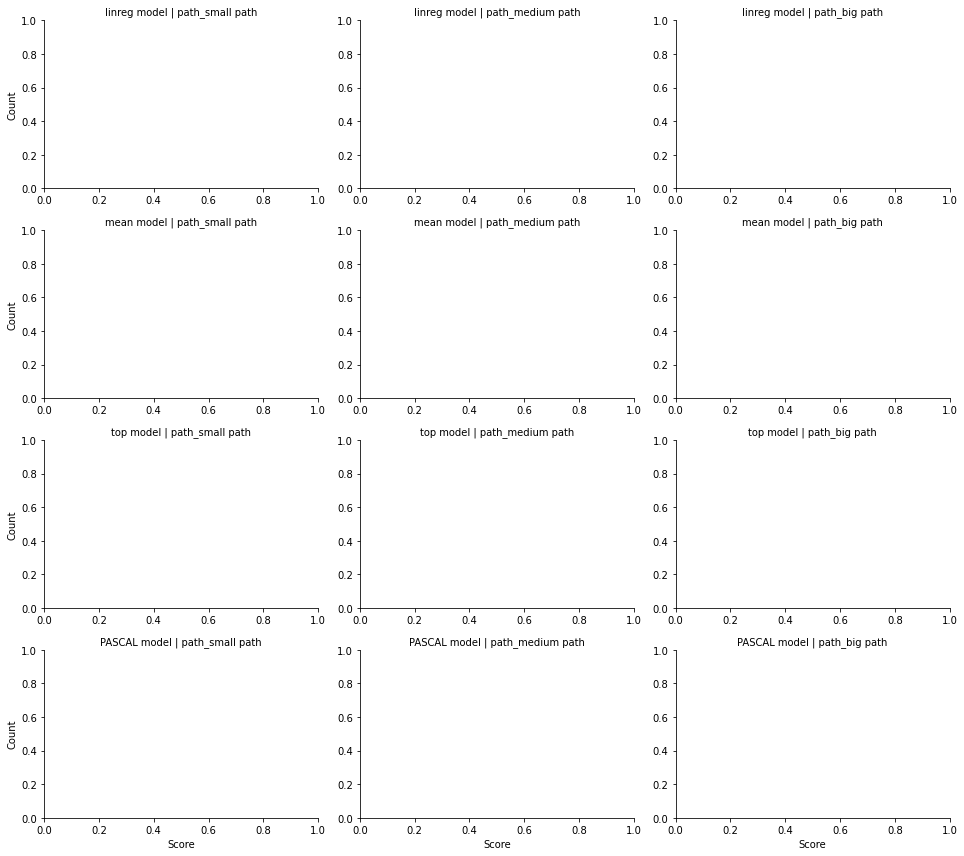

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
data = pd.read_csv('out_data/TPR_to_draw.csv')

# Display the first few rows
data.head()

# Function to plot the histogram and the min/max lines for each subset of the data
def plot_hist(data, **kwargs):
    ax = plt.gca()
    data.dropna().plot(kind='hist', ax=ax, bins=30, alpha=0.5, color='blue')
    ax.axvline(data['min'].mean(), color='red', linestyle='dashed')
    ax.axvline(data['max'].mean(), color='green', linestyle='dashed')

# Create a FacetGrid grouped by model and path
g = sns.FacetGrid(data, row='model', col='path', height=3, aspect=1.5, sharex=False, sharey=False)
# g.map_dataframe(plot_hist, 'score')

g.set_axis_labels("Score", "Count")
g.set_titles(row_template="{row_name} model", col_template="{col_name} path")
g.tight_layout()
plt.show()